In [1]:
import numpy as np
from scipy import ndimage as nd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
# Gradient in x-direction
def Sobelx(image):
    sobelx = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])
    Ix = nd.convolve(image,sobelx)           
    return Ix


# Gradient in y-direction
def Sobely(image):
    sobely = np.array([[ 1, 2, 1],
                    [ 0, 0, 0],
                    [-1,-2,-1]])

    Iy = nd.convolve(image,sobely)
    return Iy


# Convert RGB to grayscale
def rgb2gray(image):
    image = np.array(image)
    r, c, ch = image.shape
    gray = np.zeros([r,c])

    gray = np.mean(image, axis=2)
    return gray


# Reduce image size
def reduceRes(image,factor):
    r,c = image.size
    r = int(np.floor(r/factor))
    c = int(np.floor(c/factor))
    new = image.resize((r,c))
    return new


# Box filter for smoothing
def boxFilter(image,rc):
    box = np.ones([rc,rc])/rc**2
    image = nd.convolve(image,box)
    return image


# Pad image with zeros
def pad(image,filter):
    r,c = filter.shape
    factor = int(np.floor(r/2))

    r_img, c_img = image.shape
    pad = np.zeros([r_img,factor])
    image = np.hstack([pad,image,pad])

    r_img, c_img = image.shape
    pad = np.zeros([factor,c_img])
    image = np.vstack([pad,image,pad])

    return image


# Normalized Cross Correlation
def norm_cross_corr(image,filter):
    r,c = image.shape
    ncc = np.zeros([r,c])
    
    padded = pad(image,filter)

    for i in range(r):
        for j in range(c):
            f = padded[i:i+filter.shape[0],j:j+filter.shape[1]]
            len_f = np.sqrt(np.sum(f**2))
            if len_f==0:
                norm_f = np.zeros(f.shape)
            else:
                norm_f = f/len_f
            norm_g = filter/np.sqrt(np.sum(filter**2))
            
            norm_f = np.reshape(norm_f,[1,filter.size])
            norm_g = np.reshape(norm_g,[filter.size,1])
            ncc[i,j] = np.dot(norm_f,norm_g)
            
    return ncc


# Harris Corner Detector
def HarrisCorner(image,threshold,width,k):
    
    # Peak finding for nonmax supression
    def peaks(image,window):
        factor = int(np.floor(window.shape[0]/2))
        image = pad(image,window)
        peaks = np.zeros([image.shape[0],image.shape[1]])

        for i in range(1,image.shape[0]-1):
            for j in range(1,image.shape[1]-1):
                window = image[i-1:i+2,j-1:j+2]
                if image[i,j]==np.amax(window):
                    peaks[i,j] = image[i,j]


        # remove padding
        peaks = peaks[factor:-factor,factor:-factor]

        return peaks

    # remove corners that are near the edge
    def nearEdge(corners,width):

        r,c = corners.shape
        edge = int(np.floor((width-1)/2))
        corners[0:edge,:] = 0
        corners[r-edge:r,:] = 0

        corners[:,0:edge] = 0
        corners[:,c-edge:c] = 0

        return corners


    # Find gradients
    Ix = Sobelx(image)
    Iy = Sobely(image)
    Ixx = Ix**2
    Iyy = Iy**2

    # Compute R values
    detM = Ixx*Iyy
    traceM = Ixx+Iyy
    R = detM - k*traceM**2

    # Threshold values
    R[R <= threshold*np.amax(R)] = 0
    
    # Nonmax Supression
    R = peaks(R,np.ones([3,3]))

    # Remove corners near the edge
    R = nearEdge(R,width)

    return R


# Reduce threshold until ~1% of pixels are corners
def reducedHarris(image,width,k,density):

    threshold = 1.0
    ratio = density+1
    while ratio >= density:
        threshold = 0.9*threshold

        corners = HarrisCorner(image,threshold,width,k)
        # Number of corners
        idx = np.where(corners>0)
        idx = np.array(idx).T
        ratio = image.size/idx.shape[0]
    
    print('Corners:',idx.shape[0])

    return corners


# Draw lines between matches
def drawLines(image1,image2,matches,threshold):

    offset = image1.shape[0]
    x = np.copy(matches[:,0:4:2])
    x[:,1] = x[:,1] + offset
    y = np.copy(matches[:,1:4:2])

    both = np.vstack([image1,image2])
    plt.imshow(both,cmap='gray')
    for i in range(0,x.shape[0]):
        if matches[i,-1] >= threshold:
            plt.plot(y[i,:],x[i,:])
    plt.axis('off')
    
    return


# Normalized Cross Correlation of two equal shaped patches
def patchNCC(f,g):

    len_f = np.sqrt(np.sum(f**2))
    norm_f = f/len_f

    len_g = np.sqrt(np.sum(g**2))
    norm_g = g/len_g

    norm_f = np.reshape(norm_f,[1,f.size])
    norm_g = np.reshape(norm_g,[g.size,1])
    ncc = np.dot(norm_f,norm_g)
            
    return ncc


# Find matches from im1 to im2
def patch2patch(im1,im2,corners1,corners2,width,num_matches):

    # Patch from location
    def getPatch(im,r,c,width):
        left = int( (width-1)/2 )
        right = int( (width-1)/2 + 1 )
        patch = im[r-left:r+right,c-left:c+right]
        return patch

    def cornerCoord(corners):
        idx = np.where(corners>0)
        idx = np.array(idx).T
        return idx

    # Find patch coordinates
    coord1 = cornerCoord(corners1)
    coord2 = cornerCoord(corners2)

    matches = np.zeros([num_matches,5])
    
    i = 0
    while i<num_matches:
        r1 = coord1[i,0]
        c1 = coord1[i,1]
        match = np.array([r1,c1,0,0,0])
  
        # Match the patch to second image
        patch1 = getPatch(im1,r1,c1,width)
    
        for j in range(coord2.shape[0]):
            r2 = coord2[j,0]
            c2 = coord2[j,1]
            patch2 = getPatch(im2,r2,c2,width)

            ncc = patchNCC(patch1,patch2)
            if ncc >= match[4]:
                match = [r1,c1,r2,c2,ncc]

        matches[i,:] = match
        i+=1

    return matches

# Load Image, Reduce Size, Convert to Gray

In [3]:
# Load image1
file = 'DanaHallWay1/DSC_0282.JPG'
file = 'DanaOffice/DSC_0308.JPG'
image = Image.open(file)


resize = np.max(image.size)/100

# Reduce resolution
image1 = reduceRes(image,resize)
# Convert to grayscale
gray1 = rgb2gray(image1)

# Load image2
file = 'DanaHallWay1/DSC_0283.JPG'
file = 'DanaOffice/DSC_0309.JPG'
image = Image.open(file)
# Reduce resolution
image2 = reduceRes(image,resize)
# Convert to grayscale
gray2 = rgb2gray(image2)

# Add blurring to reduce noise level

In [4]:
# Smooth image
blur = 3
im1 = boxFilter(gray1,blur)
im2 = boxFilter(gray2,blur)

Finding corners...
Corners: 67
Corners: 67


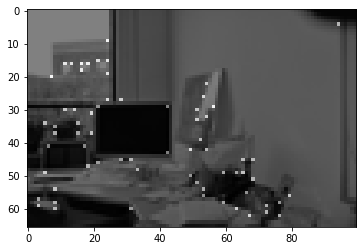

In [5]:
# Find sparse corners
print('Finding corners...')
width = 7
k = 0.05
density = 100
corners1 = reducedHarris(im1,width,k,density)
corners2 = reducedHarris(im2,width,k,density)

plt.imshow(gray1,cmap='gray')
plt.imshow(corners1>0,cmap='gray',alpha=0.5)

Finding matches...


/tmp/ipykernel_8208/2385495382.py:236: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  matches[i,:] = match


67 matches found.


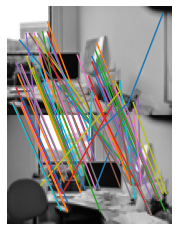

In [9]:
# Find matches
print('Finding matches...')
num_matches = np.sum(corners1>0)
matches = patch2patch(im1,im2,corners1,corners2,width,num_matches)
print(matches.shape[0],'matches found.')
drawLines(gray1,gray2,matches,0.95)
plt.savefig('matches95.png', dpi=200, bbox_inches='tight', pad_inches=0)

In [10]:
print(matches)

[[ 4.         94.         44.         53.          0.99421853]
 [ 9.         24.          9.         49.          0.99712646]
 [15.         21.         30.         37.          0.98941555]
 [15.         24.         15.         49.          0.99758945]
 [16.         11.         31.         21.          0.99040171]
 [16.         13.         42.         75.          0.99015937]
 [16.         16.         30.         37.          0.99108174]
 [16.         18.         42.         75.          0.98920631]
 [18.         16.         33.         77.          0.99004989]
 [19.         24.          9.         49.          0.99647086]
 [20.          7.         39.         78.          0.99189857]
 [22.         54.         22.         80.          0.99784975]
 [26.         53.         26.         79.          0.99953832]
 [27.         24.         27.         50.          0.99745256]
 [27.         28.         27.         53.          0.99557921]
 [29.         21.         29.         47.          0.99

KeyboardInterrupt: 

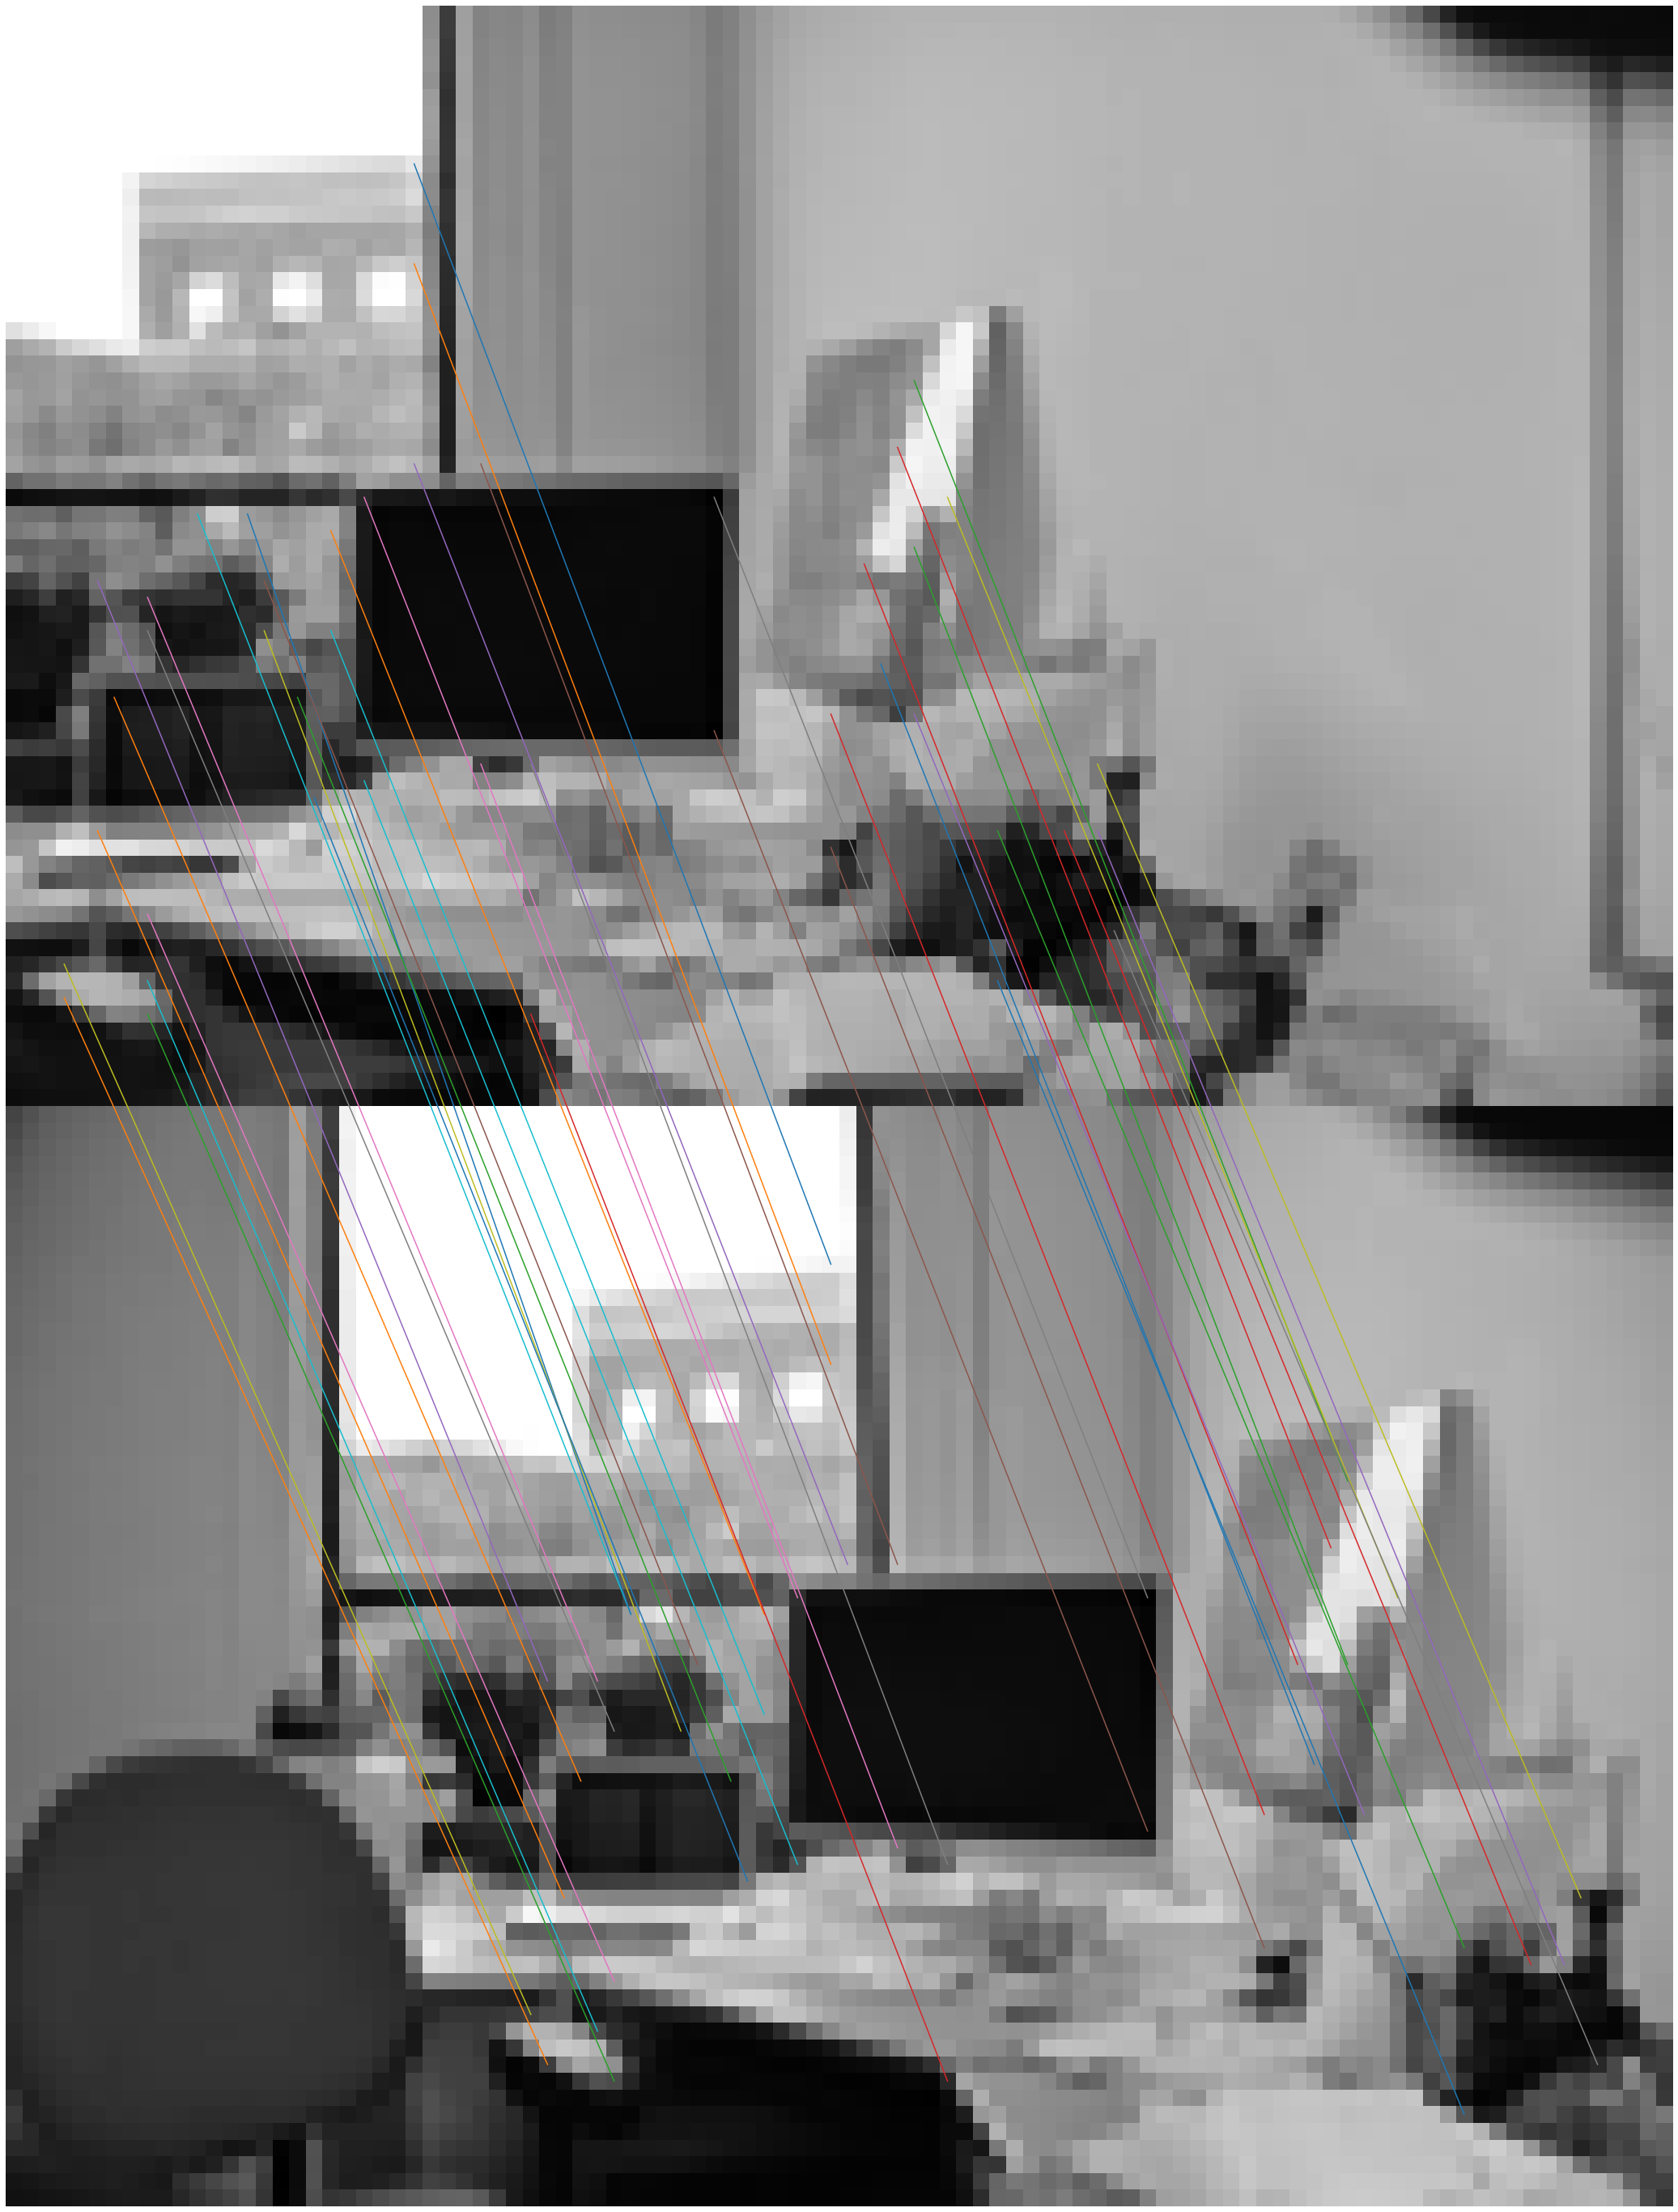

In [29]:
vector = matches[:,0] - matches[:,2]
#print(vector)
good = matches[(vector>=-3) & (vector<=3),:]

drawLines(gray1,gray2,good,0.95)
plt.savefig('afterRANSAC.png', dpi=200, bbox_inches='tight', pad_inches=0)


In [33]:
good = [[g[1], g[0], g[3], g[2]] for g in good]

[[24.0, 9.0, 49.0, 9.0], [24.0, 15.0, 49.0, 15.0], [54.0, 22.0, 80.0, 22.0], [53.0, 26.0, 79.0, 26.0], [24.0, 27.0, 50.0, 27.0], [28.0, 27.0, 53.0, 27.0], [21.0, 29.0, 47.0, 29.0], [42.0, 29.0, 68.0, 29.0], [56.0, 29.0, 83.0, 29.0], [11.0, 30.0, 37.0, 30.0], [14.0, 30.0, 37.0, 30.0], [19.0, 31.0, 45.0, 30.0], [54.0, 32.0, 80.0, 33.0], [51.0, 33.0, 77.0, 33.0], [5.0, 34.0, 32.0, 34.0], [15.0, 34.0, 41.0, 33.0], [8.0, 35.0, 35.0, 34.0], [8.0, 37.0, 36.0, 37.0], [15.0, 37.0, 40.0, 37.0], [19.0, 37.0, 45.0, 36.0], [52.0, 39.0, 78.0, 39.0], [6.0, 41.0, 34.0, 40.0], [17.0, 41.0, 43.0, 40.0], [49.0, 42.0, 75.0, 42.0], [54.0, 42.0, 81.0, 42.0], [42.0, 43.0, 68.0, 43.0], [28.0, 45.0, 53.0, 44.0], [31.0, 45.0, 56.0, 45.0], [65.0, 45.0, 94.0, 47.0], [21.0, 46.0, 47.0, 45.0], [18.0, 47.0, 44.0, 46.0], [5.0, 49.0, 33.0, 47.0], [59.0, 49.0, 87.0, 50.0], [63.0, 49.0, 91.0, 51.0], [65.0, 49.0, 93.0, 51.0], [49.0, 50.0, 75.0, 50.0], [8.0, 54.0, 36.0, 52.0], [66.0, 55.0, 95.0, 57.0], [3.0, 57.0, 31.0, 5

In [13]:
def calculate_homography(mappings, device):
    A = []
    for mapping in mappings:
        if isinstance(mapping, np.ndarray):
            mapping = torch.from_numpy(mapping)
        x = mapping[0].item()
        y = mapping[1].item()
        x_p = mapping[2].item()
        y_p = mapping[3].item()
        A.append([x, y, 1, 0, 0, 0, -x * x_p, -y * x_p, -x_p])
        A.append([0, 0, 0, x, y, 1, -x * y_p, -y * y_p, -y_p])

    A = torch.tensor(A).to(device)
    u, s, v = torch.linalg.svd(A)
    # Extract the minimum eigenvalue and normalize
    h = v[8].reshape(3, 3)
    h = h / h[2, 2].item()
    return h

In [14]:
def geometricDistance(correspondence, h):
    p1 = np.transpose(np.matrix([correspondence[0], correspondence[1], 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[2], correspondence[3], 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


def ransac(corr, thresh):
    import random
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculate_homography(randomFour, 'cpu')
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        print("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers


In [34]:
import torch
final_H, max_inliers = ransac(matches, 1000)

Corr size:  67  NumInliers:  7 Max inliers:  7
Corr size:  67  NumInliers:  11 Max inliers:  11
Corr size:  67  NumInliers:  5 Max inliers:  11
Corr size:  67  NumInliers:  4 Max inliers:  11
Corr size:  67  NumInliers:  8 Max inliers:  11
Corr size:  67  NumInliers:  10 Max inliers:  11
Corr size:  67  NumInliers:  8 Max inliers:  11
Corr size:  67  NumInliers:  5 Max inliers:  11
Corr size:  67  NumInliers:  4 Max inliers:  11
Corr size:  67  NumInliers:  7 Max inliers:  11
Corr size:  67  NumInliers:  5 Max inliers:  11
Corr size:  67  NumInliers:  44 Max inliers:  44
Corr size:  67  NumInliers:  6 Max inliers:  44
Corr size:  67  NumInliers:  7 Max inliers:  44
Corr size:  67  NumInliers:  4 Max inliers:  44
Corr size:  67  NumInliers:  4 Max inliers:  44
Corr size:  67  NumInliers:  4 Max inliers:  44
Corr size:  67  NumInliers:  9 Max inliers:  44
Corr size:  67  NumInliers:  7 Max inliers:  44
Corr size:  67  NumInliers:  9 Max inliers:  44
Corr size:  67  NumInliers:  7 Max inl

Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  45 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  11 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  24 Max inliers:  45
Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  45 Max inliers:  45
Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  12 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  11 Max inliers:  45
Corr size:  67  NumInliers:  29 Max inliers:  45
Corr size:  67  NumInliers:  36 Max inliers:  45
Corr size:  67  NumInliers:  5 Max inliers:  45
Corr size:  67  NumInliers:  38 

Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  20 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  5 Max inliers:  45
Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  5 Max inliers:  45
Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  12 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  17 Max inliers:  45
Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  5 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  12 Max inliers:  45
Corr size:  67  NumInliers:  13 Max 

Corr size:  67  NumInliers:  21 Max inliers:  45
Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  5 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  9 Max inliers:  45
Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  5 Max inliers:  45
Corr size:  67  NumInliers:  5 Max inliers:  45
Corr size:  67  NumInliers:  45 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  13 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  5 Max inliers:  45
Corr size:  67  NumInliers:  24 Max inliers:  45
Corr size:  67  NumInliers:  32 Max inliers:  45
Corr size:  67  NumInliers:  10 Max inliers:  45
Corr size:  67  NumInliers:  10 Max inliers:  45
Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  14 Max inliers:  45
Corr size:  67  NumInliers:  5 Max inliers:  45
Corr size:  67  NumInliers:  7 M

Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  5 Max inliers:  45
Corr size:  67  NumInliers:  9 Max inliers:  45
Corr size:  67  NumInliers:  45 Max inliers:  45
Corr size:  67  NumInliers:  10 Max inliers:  45
Corr size:  67  NumInliers:  11 Max inliers:  45
Corr size:  67  NumInliers:  31 Max inliers:  45
Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  27 Max inliers:  45
Corr size:  67  NumInliers:  45 Max inliers:  45
Corr size:  67  NumInliers:  9 Max inliers:  45
Corr size:  67  NumInliers:  5 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  45 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  3 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  25 Max inliers:  45
Corr size:  67  NumInliers:  45 

Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  15 Max inliers:  45
Corr size:  67  NumInliers:  24 Max inliers:  45
Corr size:  67  NumInliers:  3 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  3 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  9 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  45 Max inliers:  45
Corr size:  67  NumInliers:  10 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  6 Max i

In [38]:
import cv2
pts = np.array(good)[:, :]
print(pts.shape)

srce_pts = pts[:, :2].reshape(-1, 1, 2)
print(srce_pts.shape)

dest_pts = pts[:, 2:].reshape(-1, 1, 2)
print(pts[:, 2:].shape)
homographyMat_1, mask = cv2.findHomography(srce_pts, dest_pts, cv2.RANSAC, 1.0)

(44, 4)
(44, 1, 2)
(44, 2)


[[ 7.95912908e-01  3.22382123e-02  2.68961920e+01]
 [-5.23740500e-02  9.20671764e-01  1.73374663e+00]
 [-2.16500032e-03 -2.91808149e-05  1.00000000e+00]]
0 139 -4 73
[0, 4]


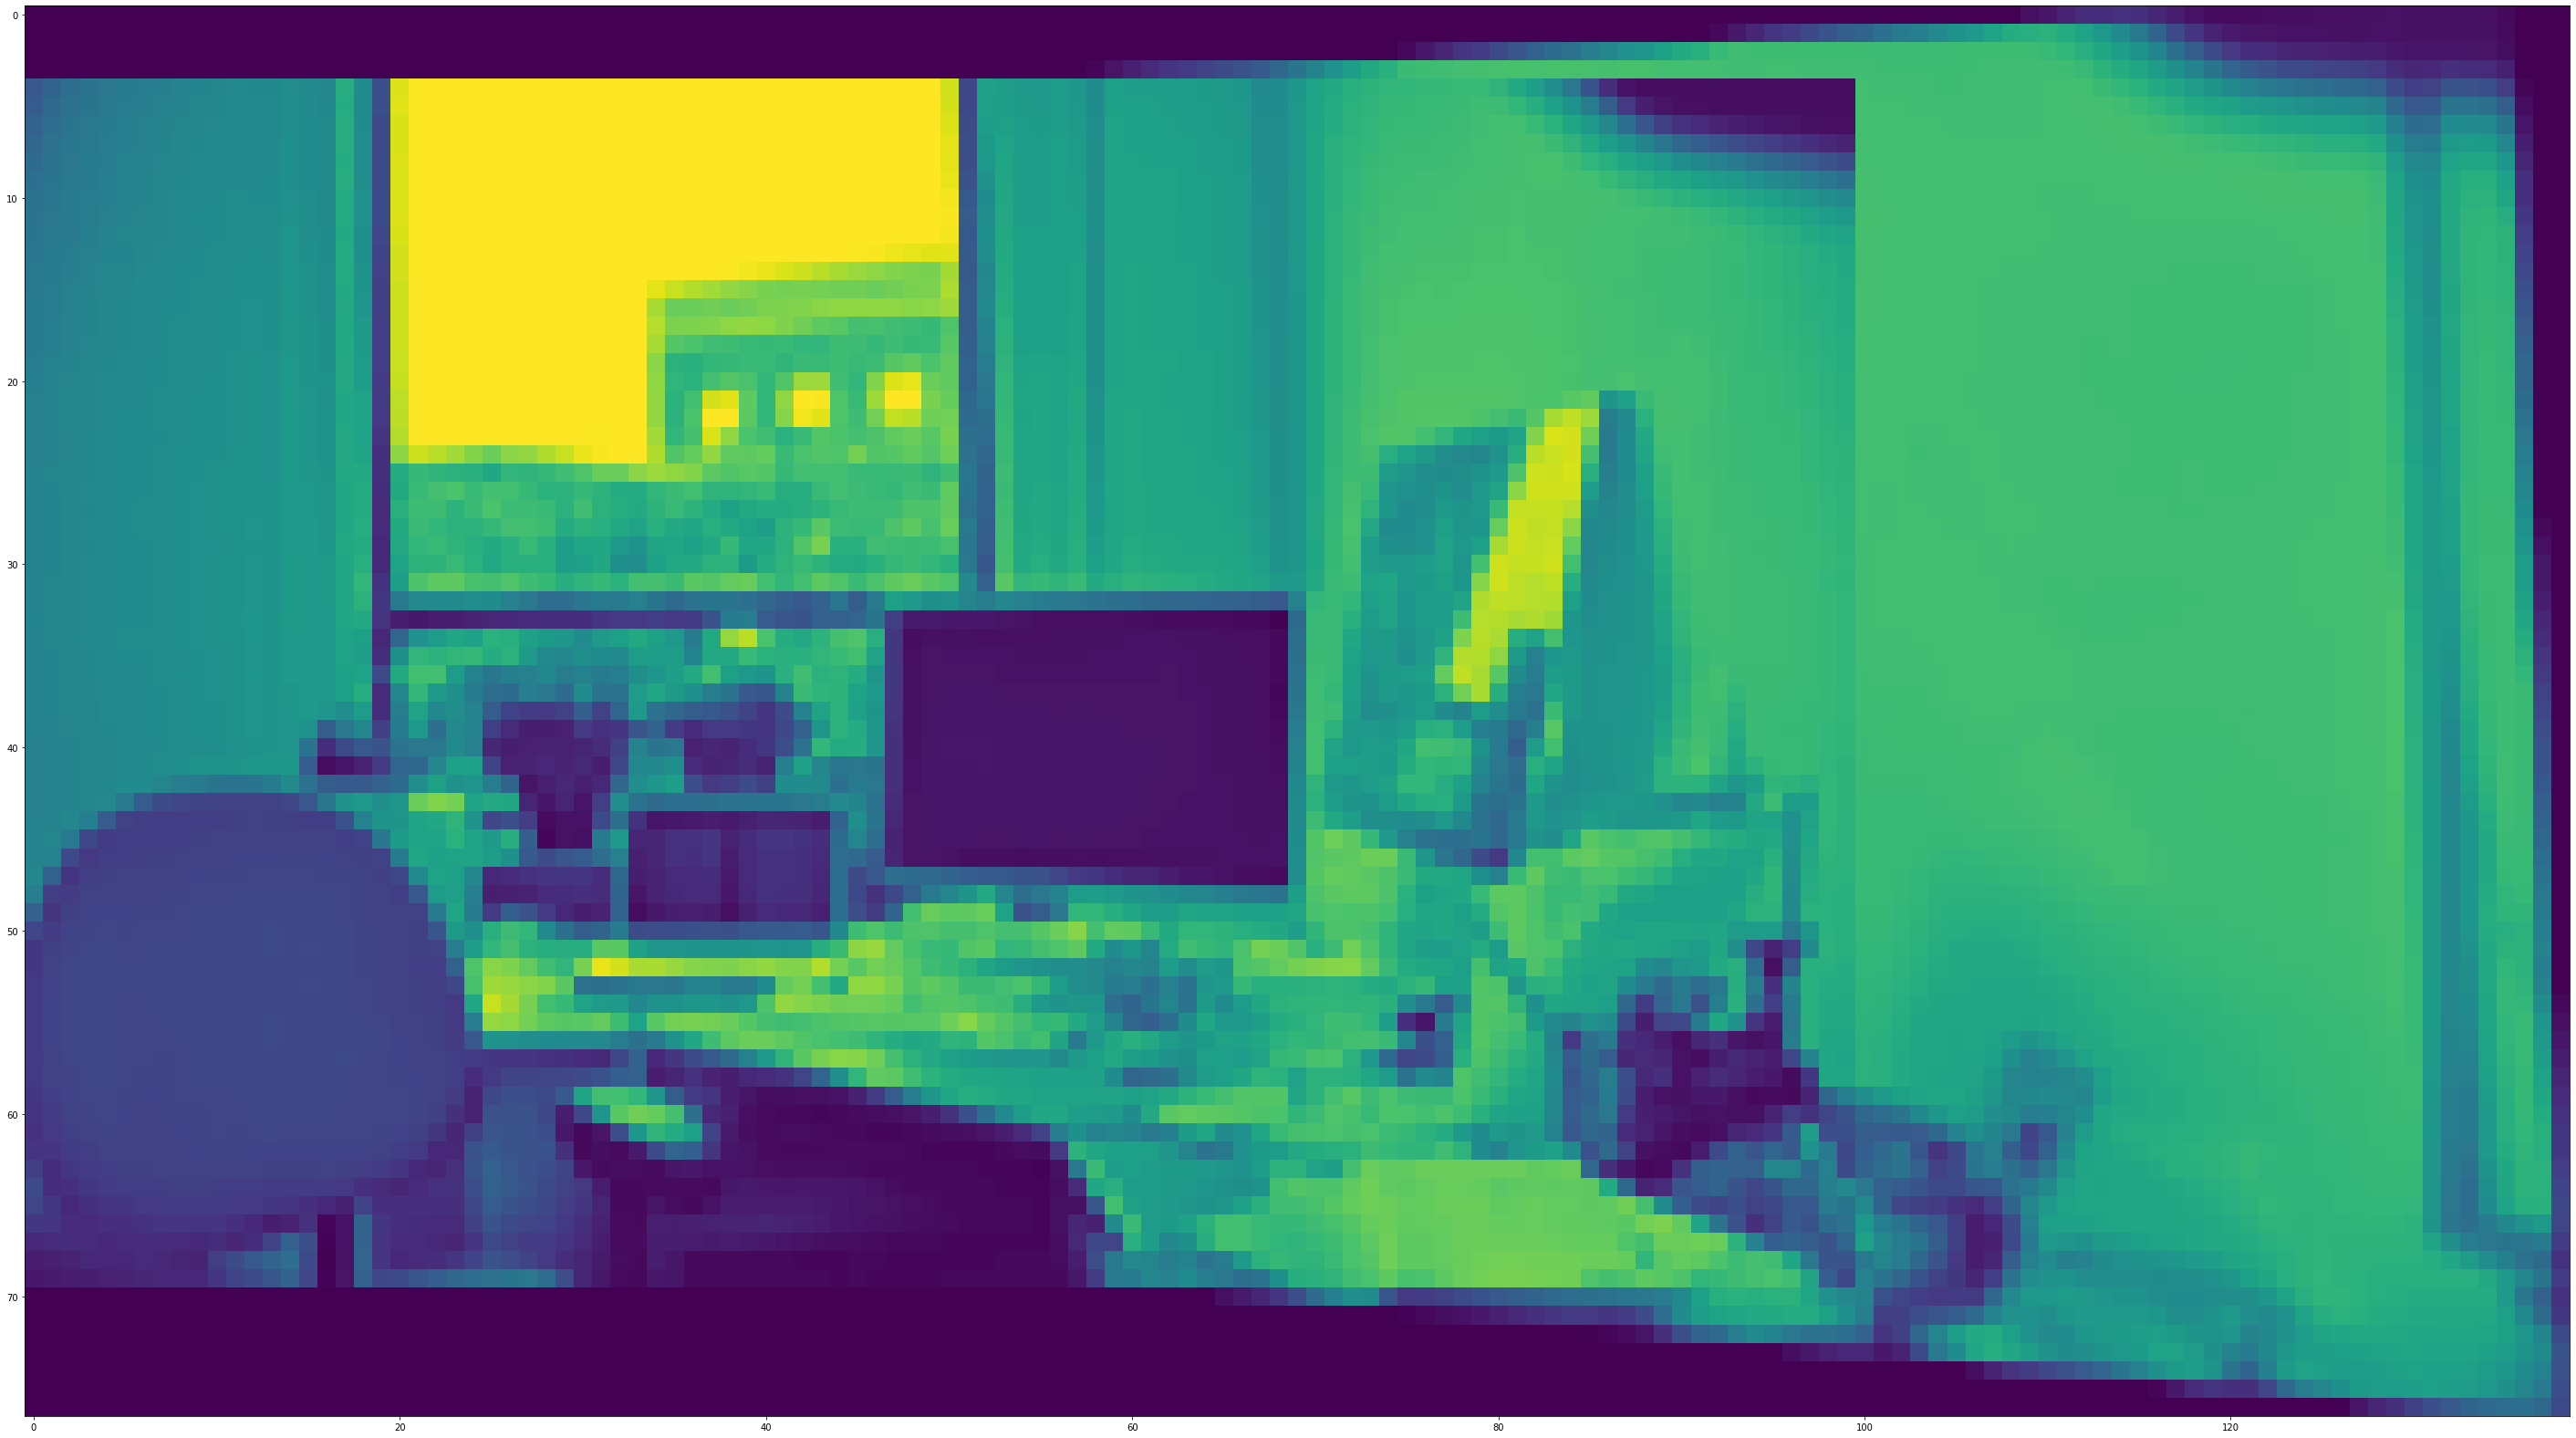

(66, 100)

In [40]:
h1, w1 = gray1.shape[:2]
h2, w2 = gray2.shape[:2]
pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
pts2_ = cv2.perspectiveTransform(pts1, homographyMat_1)
pts = np.concatenate((pts1, pts2_), axis=0)
print(homographyMat_1)

#Finding the minimum and maximum coordinates
[xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)


print(xmin, xmax, ymin, ymax)
t = [-xmin, -ymin]
print(t)
#Translating
Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])



# Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

result = cv2.warpPerspective(gray1, Ht.dot(homographyMat_1),  (xmax-xmin, ymax-ymin))
# h1, w1 = gray2.shape
result[t[1]:h1+t[1], t[0]:w1+t[0]] = gray2
# result[:66, :100] = gray2
plt.imshow(result)
# plt.show()
# plt.imshow(gray1)
# plt.show()
# plt.imshow(gray2)
plt.show()
gray1.shape

In [24]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [50, 50]